## Backtesting
### Precio de Salida y Resultado de Órdenes de Trading
En este cuaderno se muestra como calcular si una órden abierta se cierra
con beneficio o pérdida según se establecen en el precio objetivo y el stop-loss


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

_____
### Datos 

In [3]:
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
stock_df = stock_data['REE'].loc['2017':'2018']
stock_df.head()

,open,high,low,close,vol
2017-01-02,14.545550,14.598296,14.525264,14.565837,604910
2017-01-03,14.646596,14.712387,14.358763,14.449225,1389947
2017-01-04,14.453337,14.473896,14.107937,14.144944,2580776
2017-01-05,14.103825,14.264189,14.025699,14.264189,1411916
2017-01-06,14.235406,14.334092,14.079154,14.144944,1014559


_____

A partir de una orden de compra, que esperamos por precio objetivo o por stop-loss, 
tenemos que calcular **cuál de esos precios se alcanza primero**.
Si tenemos velas de precios a resolución aceptable, comparada con la amplitud de los precios objetivo y stop,  podemos considerar que:
- El precio de ejecución corresponde al precio del evento que ocurre primero
- Si tenemos una ventana temporal límite cerraríamos a precio final de la ventana

In [5]:
windata = stock_df.iloc[0:70]
precio_objetivo = 14.75
precio_loss = 13.75

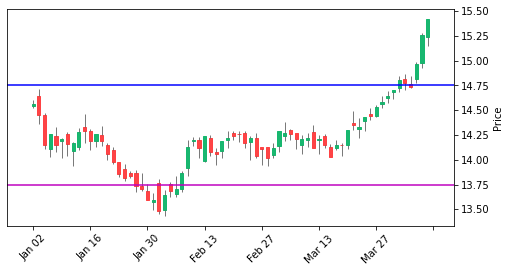

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(precio_objetivo, c='b')
ax.axhline(precio_loss, c='m')
mpf.plot(windata, ax=ax, type='candle', style='yahoo')

In [10]:
over_prices = windata.high >= precio_objetivo


In [11]:
windata.high[over_prices]

2017-03-31    14.848079
2017-04-03    14.864527
2017-04-04    14.848079
2017-04-05    14.983772
2017-04-06    15.275717
2017-04-07    15.423746
Name: high, dtype: float64

In [12]:
under_prices = windata.low <= precio_loss
windata.low[under_prices]

2017-01-26    13.676187
2017-01-27    13.680299
2017-01-30    13.593949
2017-01-31    13.495264
2017-02-01    13.454144
2017-02-02    13.429473
2017-02-03    13.626844
2017-02-06    13.626844
2017-02-07    13.676187
Name: low, dtype: float64

Bastaría con determinar por un lado si hay algun precio por encima o por debajo 
y en caso de ocurrir, saber cuál de los dos eventos ocurre primero

In [13]:
def out_trade_bar(windata, p_target, p_loss):
    """Función que calcula para una ventana, la fecha y el precio de lo que ocurra primero.
      - Que se llegue al precio objetivo
      - Que se toque el precio stop
      - Que finalice la ventana del trade y se cierre la posicón
    """
    
    # si no hay ejecución asumimos salida al final de la ventana
    trade_date = windata.index[-1]
    trade_price = windata.close.iloc[-1]
    
    over_prices = windata.high >= p_target
    if over_prices.any():
        trade_date = windata.high[over_prices].index[0]
        trade_price = p_target

    under_prices = windata.low <= p_loss
    if under_prices.any() and windata.low[under_prices].index[0] < trade_date:
        trade_date = windata.low[under_prices].index[0]
        trade_price = p_loss

    return trade_date, trade_price

In [14]:
out_trade_bar(windata, precio_objetivo, precio_loss)

(Timestamp('2017-01-26 00:00:00'), 13.75)

In [15]:
out_trade_bar(windata, precio_objetivo, 13.00)

(Timestamp('2017-03-31 00:00:00'), 14.75)

In [16]:
out_trade_bar(windata, 16.00, 13.00)

(Timestamp('2017-04-07 00:00:00'), 15.423745722)

___
### Distribución de Resultados

In [17]:
win_size = 50

In [18]:
stock_df.index.get_loc('2017-01-26')

18

In [19]:
def trade_distribution(stock_df, target_ret, loss_ret, win_size):
    results = {}
    durations = {}

    for idate in stock_df.index[:-(win_size+1)]:
        idx = stock_df.index.get_loc(idate)
        p_in = stock_df.close.loc[idate]
        windata = stock_df.iloc[idx + 1: idx+ win_size + 1]

        target = p_in * (1 + target_ret)
        loss = p_in * (1 - loss_ret)

        trade_date, p_out = out_trade_bar(windata, target, loss)
        results[idate] = p_out/p_in - 1
        durations[idate] = stock_df.index.get_loc(trade_date) - idx
    return pd.Series(results), pd.Series(durations)

In [20]:
trade_rets, trade_durations = trade_distribution(stock_df=stock_df,
                                                 target_ret = 0.06,
                                                 loss_ret = 0.03,
                                                 win_size=30)

0.010333603098832383


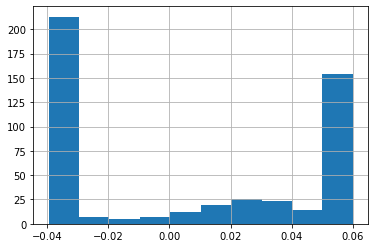

In [21]:
print(trade_rets.mean())
trade_rets.hist()

In [22]:
trade_durations.describe()

count    479.000000
mean      17.093946
std        9.923217
min        1.000000
25%        8.000000
50%       16.000000
75%       30.000000
max       30.000000
dtype: float64

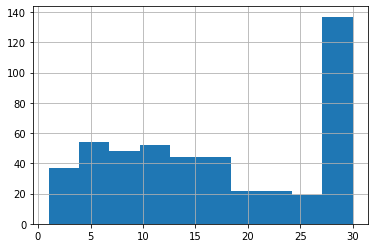

In [23]:
trade_durations.hist()

___
Exploramos la media de resultados sobre un espacio de parámetros

In [24]:
target_space = list(range(2, 15, 2))
loss_space = list(range(2, 15, 2))
win_size = 30
res_matrix = pd.DataFrame(0, index=target_space, columns=loss_space)
dur_matrix = pd.DataFrame(0, index=target_space, columns=loss_space)
for itarget in target_space:
    print(f'computing target {itarget}...')
    for jloss in loss_space:
        rets, durs = trade_distribution(stock_df=stock_df,
                                        target_ret = itarget/100.0,
                                        loss_ret = jloss/100.0,
                                        win_size=win_size)
        res_matrix.loc[itarget, jloss] = rets.mean()
        dur_matrix.loc[itarget, jloss] = durs.mean()


        

computing target 2...
computing target 4...
computing target 6...
computing target 8...
computing target 10...
computing target 12...
computing target 14...


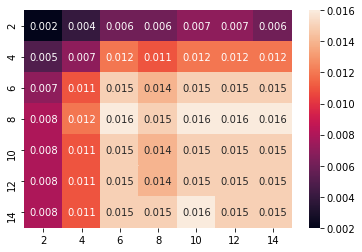

In [26]:
sns.heatmap(res_matrix.round(3), annot=True)

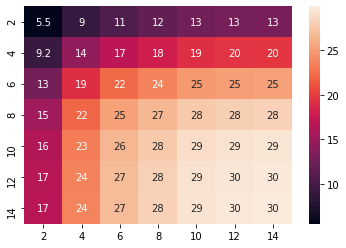

In [25]:
sns.heatmap(dur_matrix.round(3), annot=True)

____
### Observaciones Finales
- Aquí hemos explorado el resultado sobre trades sobre todos los días posibles
- Tiene sentido ver el cambio sobre una selección de días, por ejemplo a partir de nuestras señales de entrada